# Predict Student Performance from Game Play

The goal of this competition is to predict student performance during game-based learning in real-time. We developed deep learning models, trained the datasets of game logs and achieved the best F1 score of 0.649.

### Importing Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
from tensorflow import keras # data modelling
import tensorflow as tf # data modelling
import matplotlib.pyplot as plt # data visualization

### Data Loading

In [ ]:
# all the column names in train.csv
colnames = ['session_id', 'index', 'elapsed_time', 'event_name', 'name', 'level',
       'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
       'hover_duration', 'text', 'fqid', 'room_fqid', 'text_fqid',
       'level_group']

# reading csv file and defining dtypes for each column
train = pd.read_csv("train.csv", usecols=colnames, 
                dtype = {'index':np.int16, 'level':np.int8, 'page':np.float32, 'room_coor_x':np.float32, 
                        'room_coor_y':np.float32, 'screen_coor_x':np.float16, 'screen_coor_y':np.float16, 
                        'hover_duration':np.float32, 'event_name':'category', 'name':'category', 
                        'text':'category', 'fqid':'category', 'room_fqid':'category', 
                        'level_group':'category'})

### Data Preprocessing

In [ ]:
def describe_all(df):
    pd.set_option('display.max_rows', df.shape[1])  #display all rows of data
    print(f'(rows, columns){df.shape} Datatype Counts:{dict(df.dtypes.value_counts())}')  
    desc = train.describe(include='all').transpose()
    desc['Datatype'] = train.dtypes
    desc['%missing'] = train.isnull().sum().values / len(train) #handling null values
    desc['Value0'] = train.head().transpose()[0]
    desc['Value1'] = train.head().transpose()[1]
    desc['Value2'] = train.head().transpose()[2]
    desc['Value3'] = train.head().transpose()[3]
    desc['Value4'] = train.head().transpose()[4]
    return desc

In [ ]:
# Train Labels are in a separate file
# Reading the train_labels dataset
train_label = pd.read_csv("train_labels.csv")

In [ ]:
# For each session id there are multiple questions. We split the question number from the session id
train_label['session'] = train_label.session_id.apply(lambda x: int(x.split('_')[0]) )
train_label['q'] = train_label.session_id.apply(lambda x: int(x.split('_')[-1][1:]) ) # returns the last split item ([-1]) and remove the first character of that item ([1:]) which is q

print("Train_labels shape: ", train_label.shape )

Train_labels shape:  (424116, 4)


In [ ]:
# Separate numerical features and categorical features for processing
categorical_features = train.select_dtypes(include = ["category","object","bool"]).columns
numerical_features = train.select_dtypes(include = ["int8","int16","int64","float16","float32","float64"]).columns
categorical_features = categorical_features.drop("level_group")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))

Numerical features : 10
Categorical features : 6


### Deep Learning Model

##### Preprocessing Continued: Handling missing values for numerical and categorical features

In [ ]:
# Importing Libraries
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GroupKFold
from sklearn.metrics import f1_score

In [ ]:
def encode_fill(train):
    # Handling missing values for numerical features by using median as replacement
    print("NAs for numerical features: " + str(train[numerical_features].isnull().values.sum()))
    train[numerical_features] = train[numerical_features].fillna(train[numerical_features].median())
    print("After Processing:")
    print("NAs for numerical features: " + str(train[numerical_features].isnull().values.sum()))
    print(" ")
    # Use OrdinalEncoder to encode categorical 
    encoder = OrdinalEncoder()
    train[categorical_features] = encoder.fit_transform(train[categorical_features])
    # Handle missing values for categorical features
    print("NAs for categorical features: " + str(train[categorical_features].isnull().values.sum()))
    train[categorical_features] = train[categorical_features].fillna(method="ffill")
    print("After Processing:")
    print("NAs for categorical features: " + str(train[categorical_features].isnull().values.sum()))
    train[categorical_features] = train[categorical_features].fillna(0)
    print("NAs for categorical features: " + str(train[categorical_features].isnull().values.sum()))

In [ ]:
encode_fill(train)

NAs for numerical features: 58320192
After Processing:
NAs for numerical features: 0
 
NAs for categorical features: 41633924
After Processing:
NAs for categorical features: 0
NAs for categorical features: 0


##### Feature Engineering

In [ ]:
# the process of selecting, manipulating, and transforming raw data into features that can be used in model learning.
def feature_engineer(train):
    
    dfs = []
    for i in categorical_features:
        temp = train.groupby(['session_id','level_group'])[i].agg('nunique')
        temp.name = temp.name + '_nunique'
        dfs.append(temp)
    for i in numerical_features:
        temp = train.groupby(['session_id','level_group'])[i].agg('mean')
        temp.name = temp.name + '_mean'
        dfs.append(temp)
    for i in numerical_features:
        temp = train.groupby(['session_id','level_group'])[i].agg('std')
        temp.name = temp.name + '_std'
        dfs.append(temp)
    for i in numerical_features:
        temp = train.groupby(['session_id','level_group'])[i].agg('max')-train.groupby(['session_id','level_group'])[i].agg('min')
        temp.name = temp.name + '_delta'
        dfs.append(temp)
    for i in categorical_features:
        temp = train.groupby(['session_id','level_group'])[i].agg('count')
        temp.name = temp.name + '_count'
        dfs.append(temp)
    for i in categorical_features:
        temp = train.groupby(['session_id','level_group'])[i].agg('sum')
        temp.name = temp.name + '_sum'
        dfs.append(temp)
    
        
    feature_engineered = pd.concat(dfs,axis=1)
    feature_engineered = feature_engineered.fillna(-1)
    feature_engineered = feature_engineered.reset_index()
    feature_engineered = feature_engineered.set_index('session_id')
    return feature_engineered

In [ ]:
# Feature Engineer Train 
df_tr = feature_engineer(train)
print(df_tr.head())

                  level_group  event_name_nunique  name_nunique  text_nunique  \
session_id                                                                      
20090312431273200         0-4                  10             3            56   
20090312431273200       13-22                  10             3           169   
20090312431273200        5-12                  10             3           125   
20090312433251036         0-4                  11             4            49   
20090312433251036       13-22                  11             6           183   

                   fqid_nunique  room_fqid_nunique  text_fqid_nunique  \
session_id                                                              
20090312431273200            30                  7                 17   
20090312431273200            50                 12                 36   
20090312431273200            39                 11                 25   
20090312433251036            22                  6                 

In [ ]:
train = []

In [ ]:
# Define features 
FEATURES = [c for c in df_tr.columns if c != 'level_group']
UNIQUE_ID = df_tr.index.unique()
print('We will train with', len(FEATURES) ,'features and ', len(UNIQUE_ID) ,'users info')

We will train with 48 features and  23562 users info


### Model 1 - Keras Sequential Model
#### Activation Function - 'elu'
#### Hidden dense layers = 5
#### Batch Normalization and Dropout Rate 20%

In [ ]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(UNIQUE_ID),18)), index=UNIQUE_ID)
models = {}

# Compute CV Score with 5 Group K Fold
for i, (train_index, test_index) in enumerate(gkf.split(X=df_tr, groups=df_tr.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
        
    # Iterating from Questions 1-18
    for t in range(1,19):
        print(t,', ',end='')
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # Training Data
        train_x = df_tr.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = train_label.loc[train_label.q==t].set_index('session').loc[train_users]
        
        # Validation Data
        valid_x = df_tr.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = train_label.loc[train_label.q==t].set_index('session').loc[valid_users]
        
        # Training Model
        keras.backend.clear_session()
          
        model = keras.models.Sequential([
            keras.layers.Dense(256,activation="elu"), # input layer with 256 neurons
            
            keras.layers.Dense(128,activation="elu"), # dense hidden layer with 128 neurons
            keras.layers.Dropout(0.2),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(64,activation="elu"),  # dense hidden layer with 64 neurons
            keras.layers.Dropout(0.2),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(128,activation="elu"),  # dense hidden layer with 128 neurons
            keras.layers.Dropout(0.2),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(64,activation="elu"),  # dense hidden layer with 64 neurons
            keras.layers.Dropout(0.2),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(32,activation="elu"),  # dense hidden layer with 32 neurons
            keras.layers.Dropout(0.2),
            keras.layers.BatchNormalization(),
            
            keras.layers.Dense(1, activation="sigmoid") # output layer with 1 output
        ])

        model.compile(loss='binary_crossentropy',
        optimizer=keras.optimizers.Nadam(learning_rate=0.05), 
        metrics=['accuracy']
        )

        history = model.fit(train_x[FEATURES].astype('float32'), train_y['correct'], epochs=10, verbose = 0)
        # Save Model
        models[f'{grp}_{t}'] = model
        pp = model.predict(valid_x[FEATURES].astype('float32'))
        new_arr = np.hstack((np.zeros(pp.shape), pp))
        oof.loc[valid_users, t-1] = new_arr[:,1]
    print()

#########################
### Fold 1
#########################
148/148 [==============================] - 0s 1ms/step

#########################
### Fold 2
#########################
148/148 [==============================] - 1s 7ms/step

#########################
### Fold 3
#########################
148/148 [==============================] - 2s 8ms/step

#########################
### Fold 4
#########################
148/148 [==============================] - 1s 3ms/step

#########################
### Fold 5
#########################
148/148 [==============================] - 1s 4ms/step



In [ ]:
true = oof.copy()
for i in range(18):
    temp = train_label.loc[train_label.q == i+1].set_index('session').loc[UNIQUE_ID]
    true[i] = temp.correct.values

In [ ]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

### Model Evaluation

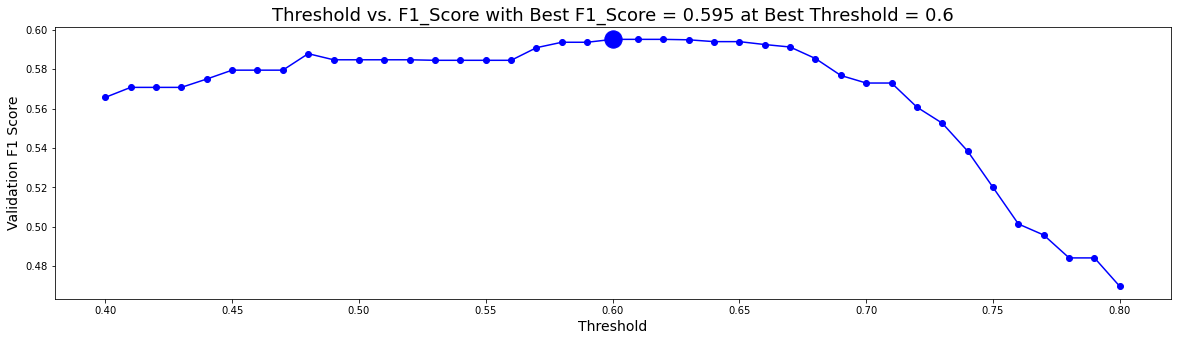

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [ ]:
for k in range(18):
        
    # Computing F1 Score per Question
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# Computing F1 Score Overall
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

Q0: F1 = 0.5012563765766721
Q1: F1 = 0.49464879356568364
Q2: F1 = 0.42006509481200877
Q3: F1 = 0.5006690050213041
Q4: F1 = 0.3111734783371338
Q5: F1 = 0.42634313464644447
Q6: F1 = 0.42398239823982403
Q7: F1 = 0.5002642213529809
Q8: F1 = 0.44089381726085386
Q9: F1 = 0.33091012352690613
Q10: F1 = 0.4671122716806988
Q11: F1 = 0.46321904544936776
Q12: F1 = 0.42025490871512233
Q13: F1 = 0.4978857569696069
Q14: F1 = 0.45178678090681745
Q15: F1 = 0.5014829745595288
Q16: F1 = 0.4877194169143756
Q17: F1 = 0.48734796893017995
==> Overall F1 = 0.5951798497713129


### Model 2 - Keras Sequential Model
#### Activation Function - 'relu'
#### Dense Hidden Layers = 4
#### Batch Normalization and Dropout rate 50%

In [ ]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(UNIQUE_ID),18)), index=UNIQUE_ID)
models = {}

# Compute CV Score with 5 Group K Fold
for i, (train_index, test_index) in enumerate(gkf.split(X=df_tr, groups=df_tr.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
        
    # Iterating from Questions 1-18
    for t in range(1,19):
        print(t,', ',end='')
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # Training Data
        train_x = df_tr.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = train_label.loc[train_label.q==t].set_index('session').loc[train_users]
        
        # Validation Data
        valid_x = df_tr.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = train_label.loc[train_label.q==t].set_index('session').loc[valid_users]
        
        # Training Model
        keras.backend.clear_session()
          
        model = keras.models.Sequential([
            keras.layers.Dense(256,activation="relu"), # input layer with 256 neurons
            
            keras.layers.Dense(128,activation="relu"), # dense hidden layer with 128 neurons
            keras.layers.Dropout(0.5),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(64,activation="relu"),  # dense hidden layer with 64 neurons
            keras.layers.Dropout(0.5),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(64,activation="relu"),  # dense hidden layer with 64 neurons
            keras.layers.Dropout(0.5),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(32,activation="relu"),  # dense hidden layer with 32 neurons
            
            keras.layers.Dense(1, activation="sigmoid") # output layer with 1 output
        ])

        model.compile(loss='binary_crossentropy',
        optimizer=keras.optimizers.Nadam(learning_rate=0.05), 
        metrics=['accuracy']
        )

        history = model.fit(train_x[FEATURES].astype('float32'), train_y['correct'], epochs=10, verbose = 0)
        # Save Model
        models[f'{grp}_{t}'] = model
        pp = model.predict(valid_x[FEATURES].astype('float32'))
        new_arr = np.hstack((np.zeros(pp.shape), pp))
        oof.loc[valid_users, t-1] = new_arr[:,1]
    print()

#########################
### Fold 1
#########################
148/148 [==============================] - 1s 4ms/step

#########################
### Fold 2
#########################
148/148 [==============================] - 1s 3ms/step

#########################
### Fold 3
#########################
148/148 [==============================] - 2s 11ms/step

#########################
### Fold 4
#########################
148/148 [==============================] - 2s 10ms/step

#########################
### Fold 5
#########################
148/148 [==============================] - 2s 11ms/step



In [ ]:
true = oof.copy()
for i in range(18):
    temp = train_label.loc[train_label.q == i+1].set_index('session').loc[UNIQUE_ID]
    true[i] = temp.correct.values

In [ ]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

### Model Evaluation

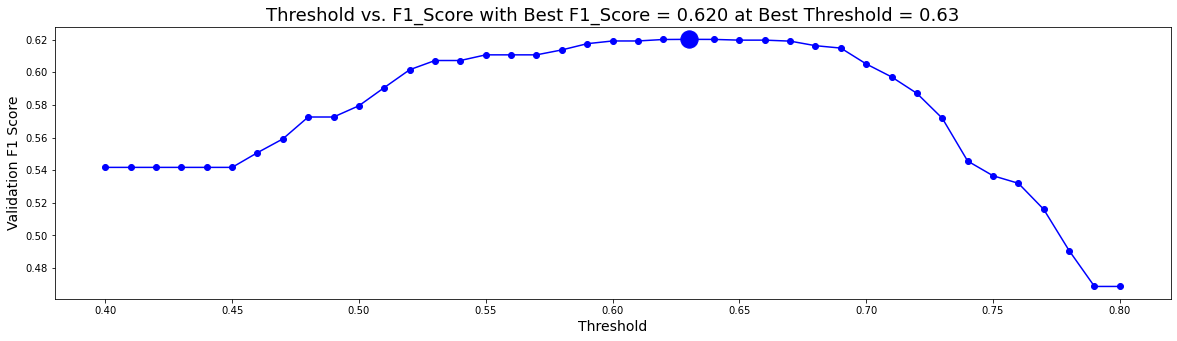

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [ ]:
for k in range(18):
        
    # Computing F1 Score per Question
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# Computing F1 Score Overall
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

Q0: F1 = 0.4883203240945769
Q1: F1 = 0.45788447658559384
Q2: F1 = 0.4809106937478688
Q3: F1 = 0.5018853783375387
Q4: F1 = 0.3111734783371338
Q5: F1 = 0.4984335092764506
Q6: F1 = 0.49895288774768454
Q7: F1 = 0.27681777723212914
Q8: F1 = 0.4240527988266927
Q9: F1 = 0.33091012352690613
Q10: F1 = 0.4797790553536424
Q11: F1 = 0.46321904544936776
Q12: F1 = 0.42025490871512233
Q13: F1 = 0.4144050104384134
Q14: F1 = 0.3416596814752724
Q15: F1 = 0.42358783668077404
Q16: F1 = 0.4075135787567894
Q17: F1 = 0.48734796893017995
==> Overall F1 = 0.6201843260440758


### Model 3 - Keras Sequential Model
#### Activation Function - 'elu'
#### Hidden dense layers = 1
#### Dropout rate 50%

In [ ]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(UNIQUE_ID),18)), index=UNIQUE_ID)
models = {}

# Compute CV Score with 5 Group K Fold
for i, (train_index, test_index) in enumerate(gkf.split(X=df_tr, groups=df_tr.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
        
    # Iterating from Questions 1-18
    for t in range(1,19):
        print(t,', ',end='')
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # Training Data
        train_x = df_tr.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = train_label.loc[train_label.q==t].set_index('session').loc[train_users]
        
        # Validation Data
        valid_x = df_tr.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = train_label.loc[train_label.q==t].set_index('session').loc[valid_users]
        
        # Training Model
        keras.backend.clear_session()
          
        model = keras.models.Sequential([
            keras.layers.Dense(32, activation="elu"), # input layer with 32 neurons
            keras.layers.Dropout(0.5),
            keras.layers.Dense(16, activation="elu"), # dense hidden layer with 16 neurons
            keras.layers.Dropout(0.25),
            keras.layers.Dense(1, activation="sigmoid") # output layer with 1 output
        ])

        model.compile(loss='binary_crossentropy',
        optimizer=keras.optimizers.Nadam(learning_rate=0.05), 
        metrics=['accuracy']
        )

        history = model.fit(train_x[FEATURES].astype('float32'), train_y['correct'], epochs=10, verbose = 0)
        # Save Model
        models[f'{grp}_{t}'] = model
        pp = model.predict(valid_x[FEATURES].astype('float32'))
        new_arr = np.hstack((np.zeros(pp.shape), pp))
        oof.loc[valid_users, t-1] = new_arr[:,1]
    print()

#########################
### Fold 1
#########################
148/148 [==============================] - 1s 3ms/step

#########################
### Fold 2
#########################
148/148 [==============================] - 0s 2ms/step

#########################
### Fold 3
#########################
148/148 [==============================] - 0s 2ms/step

#########################
### Fold 4
#########################
148/148 [==============================] - 0s 779us/step

#########################
### Fold 5
#########################
148/148 [==============================] - 0s 760us/step



In [ ]:
true = oof.copy()
for i in range(18):
    temp = train_label.loc[train_label.q == i+1].set_index('session').loc[UNIQUE_ID]
    true[i] = temp.correct.values

In [ ]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

### Model Evaluation

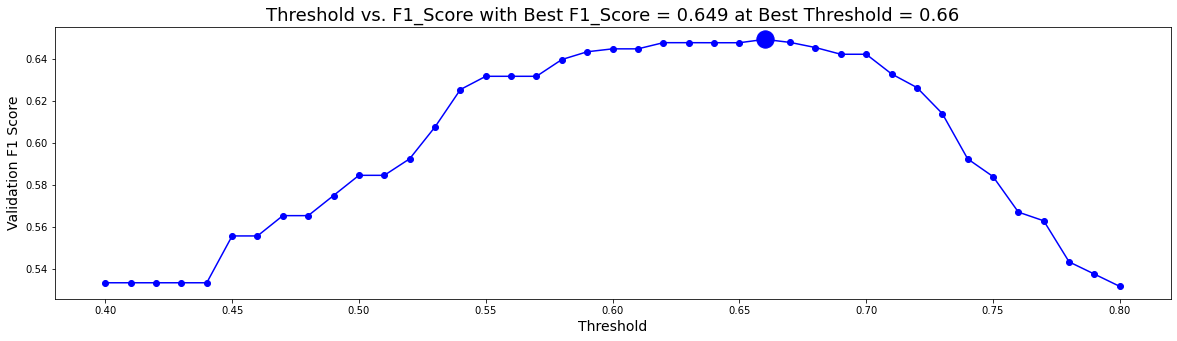

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()


In [ ]:
for k in range(18):
        
    # Computing F1 Score per Question
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# Computing F1 Score Overall
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

Q0: F1 = 0.4211237500921308
Q1: F1 = 0.49464879356568364
Q2: F1 = 0.4829379622111523
Q3: F1 = 0.4438989851309889
Q4: F1 = 0.3111734783371338
Q5: F1 = 0.43692197395148763
Q6: F1 = 0.42398239823982403
Q7: F1 = 0.27681777723212914
Q8: F1 = 0.4240527988266927
Q9: F1 = 0.33091012352690613
Q10: F1 = 0.466047235475075
Q11: F1 = 0.46321904544936776
Q12: F1 = 0.42025490871512233
Q13: F1 = 0.4144050104384134
Q14: F1 = 0.3416596814752724
Q15: F1 = 0.42358783668077404
Q16: F1 = 0.4075135787567894
Q17: F1 = 0.48734796893017995
==> Overall F1 = 0.6493539514984068


### Conclusion

#### We observe that Model 3 gives the best accuracy with F1_score of 0.649 when compared to Model 2 and Model 1. 
#### We started to build a simple sequential model with 5 hidden layers and 'elu' activation function. Later after experimenting different number of layers and neurons with relu activation function, we came to a conclusion that the activation function 'elu' gives the best results. However adding more number of hidden layers was just complicating the model and over fitting to some extent. 
#### Hence the ideal and simple model with 32neurons in input layer, 16 neurons in hidden layer and a single output layer is suffice for this dataset.